In [85]:
import pandas as pd
import numpy as np
# from dotenv import load_dotenv
from pandas.tseries.offsets import DateOffset
import os
import requests
import datetime
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.requests import CryptoLatestQuoteRequest
from alpaca.data.requests import CryptoTradesRequest
from alpaca.data.timeframe import TimeFrame
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
import matplotlib.pyplot as plt
from numpy.lib import math
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Bidirectional
from pathlib import Path
%matplotlib inline

## Data Retreival/Formatting

In [86]:
# alpaca_api_key = os.getenv("ALPACA_API_KEY")
# alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

In [87]:
# type(alpaca_api_key)

In [88]:
crypto_client = CryptoHistoricalDataClient()

In [89]:
# Pull data

request_params = CryptoBarsRequest(
    symbol_or_symbols=["BTC/USD"],
    timeframe=TimeFrame.Hour, start='2021-01-01 00:00:00'
)

btc_bars = crypto_client.get_crypto_bars(request_params)


In [90]:
# Breakpoint so I don't have to make an API call to refresh data

btc_df = btc_bars.df

btc_df

open     high      low    close  \
symbol  timestamp                                                       
BTC/USD 2021-01-01 00:00:00+00:00  28973.0  29073.5  28775.0  29065.0   
        2021-01-01 01:00:00+00:00  29070.0  29481.0  29038.5  29404.5   
        2021-01-01 02:00:00+00:00  29528.0  29528.0  29218.0  29245.0   
        2021-01-01 03:00:00+00:00  29400.5  29400.5  29337.0  29367.5   
        2021-01-01 04:00:00+00:00  29449.0  29449.0  29136.5  29189.5   
...                                    ...      ...      ...      ...   
        2022-10-08 01:00:00+00:00  19573.0  19593.0  19551.0  19592.0   
        2022-10-08 02:00:00+00:00  19592.0  19597.0  19548.0  19564.0   
        2022-10-08 03:00:00+00:00  19565.0  19565.0  19500.0  19504.0   
        2022-10-08 04:00:00+00:00  19504.0  19525.0  19419.0  19440.0   
        2022-10-08 05:00:00+00:00  19441.0  19476.0  19437.0  19474.0   

                                     volume  trade_count          vwap  
symbol  timestamp                                                       
BTC/USD 2021-01-01 00:00:00+00:00    3.4437         72.0  28968.839097  
        2021-01-01 01:00:00+00:00    4.6183         65.0  29359.399487  
        2021-01-01 02:00:00+00:00    4.3423         42.0  29361.540923  
        2021-01-01 03:00:00+00:00    0.3089          3.0  29400.447394  
        2021-01-01 04:00:00+00:00    2.0245         34.0  29302.743369  
...                                     ...          ...           ...  
        2022-10-08 01:00:00+00:00   52.5334        389.0  19581.419948  
        2022-10-08 02:00:00+00:00    0.6644        189.0  19579.694160  
        2022-10-08 03:00:00+00:00   23.3546        282.0  19516.624344  
        2022-10-08 04:00:00+00:00  154.6978        510.0  19457.443565  
        2022-10-08 05:00:00+00:00   48.6124        160.0  19451.765689  

[15464 rows x 7 columns]

In [91]:
btc_df.dtypes

open           float64
high           float64
low            float64
close          float64
volume         float64
trade_count    float64
vwap           float64
dtype: object

In [92]:
# Create dataframe

btc_df = btc_df.reset_index()
btc_df = btc_df.set_index('timestamp')
btc_df = btc_df.drop(columns=['symbol','vwap'])

btc_df

,open,high,low,close,volume,trade_count
timestamp,,,,,,
2021-01-01 00:00:00+00:00,28973.0,29073.5,28775.0,29065.0,3.4437,72.0
2021-01-01 01:00:00+00:00,29070.0,29481.0,29038.5,29404.5,4.6183,65.0
2021-01-01 02:00:00+00:00,29528.0,29528.0,29218.0,29245.0,4.3423,42.0
2021-01-01 03:00:00+00:00,29400.5,29400.5,29337.0,29367.5,0.3089,3.0
2021-01-01 04:00:00+00:00,29449.0,29449.0,29136.5,29189.5,2.0245,34.0
...,...,...,...,...,...,...
2022-10-08 01:00:00+00:00,19573.0,19593.0,19551.0,19592.0,52.5334,389.0
2022-10-08 02:00:00+00:00,19592.0,19597.0,19548.0,19564.0,0.6644,189.0
2022-10-08 03:00:00+00:00,19565.0,19565.0,19500.0,19504.0,23.3546,282.0


In [93]:
# Use the pct_change function to generate  returns from close prices
btc_df["Actual Returns"] = btc_df["close"].pct_change()

# Drop na
btc_df=btc_df.dropna()

In [94]:
# Initialize the new Signal column
btc_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
btc_df.loc[(btc_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
btc_df.loc[(btc_df['Actual Returns'] < 0), 'Signal'] = 0

btc_df.head()

C:\Users\gtkhh\AppData\Local\Temp\ipykernel_21856\2101336388.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  btc_df['Signal'] = 0.0


,open,high,low,close,volume,trade_count,Actual Returns,Signal
timestamp,,,,,,,,
2021-01-01 01:00:00+00:00,29070.0,29481.0,29038.5,29404.5,4.6183,65.0,0.011681,1.0
2021-01-01 02:00:00+00:00,29528.0,29528.0,29218.0,29245.0,4.3423,42.0,-0.005424,0.0
2021-01-01 03:00:00+00:00,29400.5,29400.5,29337.0,29367.5,0.3089,3.0,0.004189,1.0
2021-01-01 04:00:00+00:00,29449.0,29449.0,29136.5,29189.5,2.0245,34.0,-0.006061,0.0
2021-01-01 05:00:00+00:00,29240.5,29240.5,29240.5,29240.5,0.0028,1.0,0.001747,1.0


In [95]:
# Drop Actual Returns

btc_df = btc_df.drop(columns='Actual Returns')
btc_df.head()

,open,high,low,close,volume,trade_count,Signal
timestamp,,,,,,,
2021-01-01 01:00:00+00:00,29070.0,29481.0,29038.5,29404.5,4.6183,65.0,1.0
2021-01-01 02:00:00+00:00,29528.0,29528.0,29218.0,29245.0,4.3423,42.0,0.0
2021-01-01 03:00:00+00:00,29400.5,29400.5,29337.0,29367.5,0.3089,3.0,1.0
2021-01-01 04:00:00+00:00,29449.0,29449.0,29136.5,29189.5,2.0245,34.0,0.0
2021-01-01 05:00:00+00:00,29240.5,29240.5,29240.5,29240.5,0.0028,1.0,1.0


#### The following code block is necessary for traditional ML, I believe with tensors it may be unnecessary

In [96]:
# # Shift X data to predict the future Y signal value
# btc_df[['open', 'high','low','close','volume', 'trade_count']]=btc_df[['open','high','low','close','volume','trade_count']].shift()
# display(btc_df.head())

# # Drop rows w/ empty values
# btc_df = btc_df.dropna()
# display(btc_df.head())

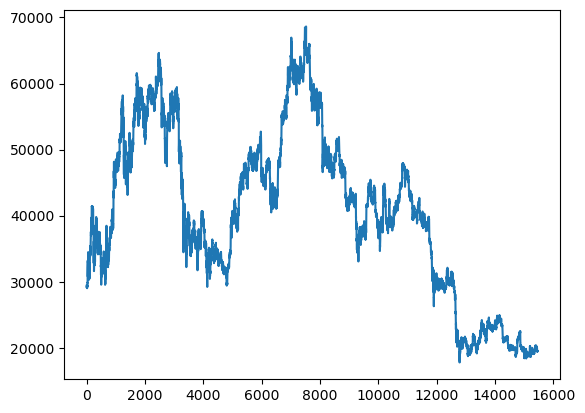

In [97]:
plt.plot(range(len(btc_df)), btc_df[['close']])

### Splitting data into 3D Tensors

In [98]:
# Split test and train data

split_ratio=.7
train_count=int(len(btc_df)*.7)

train=btc_df.iloc[:train_count]
test=btc_df.iloc[train_count:]

display(train.head())

,open,high,low,close,volume,trade_count,Signal
timestamp,,,,,,,
2021-01-01 01:00:00+00:00,29070.0,29481.0,29038.5,29404.5,4.6183,65.0,1.0
2021-01-01 02:00:00+00:00,29528.0,29528.0,29218.0,29245.0,4.3423,42.0,0.0
2021-01-01 03:00:00+00:00,29400.5,29400.5,29337.0,29367.5,0.3089,3.0,1.0
2021-01-01 04:00:00+00:00,29449.0,29449.0,29136.5,29189.5,2.0245,34.0,0.0
2021-01-01 05:00:00+00:00,29240.5,29240.5,29240.5,29240.5,0.0028,1.0,1.0


In [99]:
# Create a MinMaxScaler instance
scaler = MinMaxScaler()

# Fit the scaler to the features training dataset
train_scaled = scaler.fit_transform(train)

train_scaled

array([[1.42664158e-03, 1.03804497e-02, 3.05961893e-02, ...,
        3.74333957e-03, 1.15419297e-02, 1.00000000e+00],
       [1.29912760e-02, 1.15560669e-02, 3.50092194e-02, ...,
        3.51961948e-03, 7.39404869e-03, 0.00000000e+00],
       [9.77186360e-03, 8.36689262e-03, 3.79348494e-02, ...,
        2.50226051e-04, 3.60685302e-04, 1.00000000e+00],
       ...,
       [4.49821354e-01, 4.47660022e-01, 4.67019053e-01, ...,
        3.11740968e-02, 2.63300271e-02, 1.00000000e+00],
       [4.52699888e-01, 4.50561545e-01, 4.68985864e-01, ...,
        5.26718136e-02, 2.84941389e-02, 1.00000000e+00],
       [4.54947164e-01, 4.54488607e-01, 4.69723417e-01, ...,
        9.03601366e-02, 3.64292155e-02, 1.00000000e+00]])

In [100]:
# Scale test data
test_scaled = scaler.fit_transform(test)

test_scaled

array([[9.72624052e-01, 9.72506309e-01, 9.75310682e-01, ...,
        2.89050754e-02, 3.42267084e-02, 0.00000000e+00],
       [9.69346883e-01, 9.61747908e-01, 9.64668165e-01, ...,
        6.54317951e-03, 9.97795568e-03, 0.00000000e+00],
       [9.67559337e-01, 9.62910081e-01, 9.70683501e-01, ...,
        6.54401286e-04, 2.20443207e-03, 1.00000000e+00],
       ...,
       [5.93862756e-02, 4.85124186e-02, 6.31279746e-02, ...,
        6.46584471e-03, 3.19062536e-02, 0.00000000e+00],
       [5.73670098e-02, 4.71842210e-02, 6.04508197e-02, ...,
        4.29507581e-02, 5.83594384e-02, 0.00000000e+00],
       [5.52815386e-02, 4.55571789e-02, 6.10457430e-02, ...,
        1.34820332e-02, 1.77514793e-02, 1.00000000e+00]])

In [101]:
# Set global candles variable
candles=60

# Create X training set
X_train = []

for i in range(len(train_scaled) - candles):
    X_train.append(train_scaled[:,:5][i:i+candles])

X_train = np.array(X_train)
X_train.shape

(10764, 60, 5)

In [102]:
# Create y training set
y_train = []

for i in range(len(train_scaled) - candles):
    y_train.append(train_scaled[:,(6)][i+candles])

y_train = np.array(y_train)
y_train.shape

(10764,)

In [103]:
# Create X test set
X_test = []

for i in range(len(test_scaled) - candles):
    X_test.append(test_scaled[:,:5][i  : i+candles])

X_test = np.array(X_test)
X_test.shape

(4579, 60, 5)

In [104]:
# Create y test set
y_test = []

for i in range(len(test_scaled) - candles):
    y_test.append(test_scaled[:,(6)][i+candles])

y_test = np.array(y_test)
y_test.shape

(4579,)

## Model Creation

In [105]:
# Check if GPU is working

tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [106]:
# Create the Sequential model instance
class_nn = Sequential()

# Define the number of neurons in the output layer
number_output_neurons = 1

#Define the number of hidden nodes for the first hidden layer
hidden_nodes_layer1 = 64

# Define hidden nodes for all hidden layers
hidden_nodes = 64
display(hidden_nodes)

# Review the number hidden nodes in the first layer
display(hidden_nodes_layer1)

#Define the number of hidden nodes for the second hidden layer
hidden_nodes_layer2 = 64

# Review the number hidden nodes in the second layer
display(hidden_nodes_layer2)

kernelSize=1

64

64

64

In [107]:
# # Add first cnn layer
# class_nn.add(Conv1D(filters=32, kernel_size=kernelSize, padding='same', activation='relu', input_shape=(candles,len(X.columns))))

In [108]:
# #Add second cnn layer
# class_nn.add(Conv1D(filters=64, kernel_size=kernelSize, padding='same'))

In [109]:
# Add the first hidden layer
class_nn.add(LSTM(units=hidden_nodes, return_sequences=True,input_shape=(candles,(len(btc_df.columns)-2))))

In [110]:
# # Add dropout layer
class_nn.add(Dropout(rate=0.2))

In [111]:
#Add the second hidden layer
class_nn.add(LSTM(units=hidden_nodes, return_sequences=False))


In [112]:
# # Add dropout layer
class_nn.add(Dropout(rate=0.2))

In [113]:
# # #Add the third hidden layer
# class_nn.add(LSTM(units=hidden_nodes_layer2))

In [114]:
# # Add dropout layer
# class_nn.add(Dropout(rate=0.2))

In [115]:
# Add Dense layer
# class_nn.add(Dense(units=6, activation='relu'))

In [116]:
# Add the output layer to the model specifying the number of output neurons and activation function
class_nn.add(Dense(units=1,  activation='sigmoid'))


In [117]:
# Display the Sequential model summary, subclassed model requires build
class_nn.build(X_train.shape)
class_nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 60, 64)            17920     
                                                                 
 dropout_8 (Dropout)         (None, 60, 64)            0         
                                                                 
 lstm_9 (LSTM)               (None, 64)                33024     
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 51,009
Trainable params: 51,009
Non-trainable params: 0
_________________________________________________________________


In [118]:
# Compile the Sequential model
# class_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=('accuracy','Precision', 'Recall'))

class_nn.compile(loss='binary_crossentropy', optimizer='adam', metrics=('accuracy'))

In [119]:
# Fit the model using epochs and the training data
class_model = class_nn.fit(X_train, y_train, epochs=60, validation_split=0.1)

Epoch 1/60
303/303 [==============================] - 6s 14ms/step - loss: 0.6935 - accuracy: 0.4987 - val_loss: 0.6950 - val_accuracy: 0.5125
Epoch 2/60
303/303 [==============================] - 4s 12ms/step - loss: 0.6935 - accuracy: 0.5091 - val_loss: 0.6930 - val_accuracy: 0.5032
Epoch 3/60
303/303 [==============================] - 4s 12ms/step - loss: 0.6934 - accuracy: 0.5002 - val_loss: 0.6928 - val_accuracy: 0.5125
Epoch 4/60
303/303 [==============================] - 4s 12ms/step - loss: 0.6928 - accuracy: 0.5129 - val_loss: 0.6961 - val_accuracy: 0.4875
Epoch 5/60
303/303 [==============================] - 4s 12ms/step - loss: 0.6933 - accuracy: 0.5086 - val_loss: 0.6928 - val_accuracy: 0.5125
Epoch 6/60
303/303 [==============================] - 4s 12ms/step - loss: 0.6930 - accuracy: 0.5156 - val_loss: 0.6928 - val_accuracy: 0.5125
Epoch 7/60
303/303 [==============================] - 3s 11ms/step - loss: 0.6927 - accuracy: 0.5174 - val_loss: 0.6928 - val_accuracy: 0.5125

In [120]:
# Evaluate the model loss and accuracy metrics using the evaluate method and the test data
# model_loss, model_accuracy, model_precision, model_recall = class_nn.evaluate(X_test, y_test)

model_loss, model_accuracy = class_nn.evaluate(X_test, y_test)

# Display the model loss and accuracy results
# print(f"Loss: {model_loss}, Accuracy: {model_accuracy}, Precision: {model_precision}, Recall: {model_recall}")

print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

144/144 [==============================] - 1s 6ms/step - loss: 0.6938 - accuracy: 0.5010
Loss: 0.6937634944915771, Accuracy: 0.5009827613830566


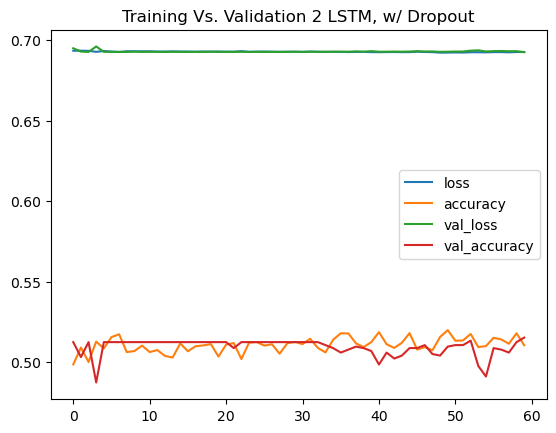

In [121]:
# Train vs test for loss
plt.plot(class_model.history["loss"])
plt.plot(class_model.history["accuracy"])
plt.plot(class_model.history["val_loss"])
plt.plot(class_model.history["val_accuracy"])
plt.title("Training Vs. Validation 2 LSTM, w/ Dropout")
plt.legend(["loss", "accuracy","val_loss","val_accuracy"])
plt.show()

In [122]:
# Set the file path for the first alternative model
file_path = Path('Models/class_class_nn.h5')

# Export your model to a HDF5 file
class_nn.save(file_path)